# CMPT-825: Natural Language Processing
## Group: Oasis
### TLDR: Text Summarization from basic to advanced approaches
#### Nattapat Juthaprachakul (njuthapr)
#### Siyu Wu (swa246)

### There are total 6 models in this project: 
1. LSTM
2. Finetuned Bart-base
3. Pretrained Bart-large 
4. Pretrained T5-small 
5. Pretrained T5-base 
6. Pretrained T5-large

### We separate model training into 3 parts:
1. Finetuned Bart-base
2. LSTM from scratch
3. Pretrained Bart-large, T5-small, T5-base, and T5-large


#####  Hardware Requirements:
This project runs on Google Colab
1. Python 3.6 and above
2. Pytorch 
3. Python ML Libraries eg. Pandas, Numpy
4. Tensorflow, Keras
5. Transformers from Huggingface
6. Optional GPU enabled setup
7. Optional TPU enabled setup
8. rouge library


## 1. BART-base Transformer: Fine Tuning for News Summarization



In [4]:
# this code runs on Google Colab

# install transformer library from Huggingface (https://huggingface.co/)
!pip install transformers -q
# install Weights & Biases service for monitoring training
!pip install wandb -q

# if using TPU, install this package 
# !curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

     |████████████████████████████████| 102kB 7.4MB/s 
     |████████████████████████████████| 102kB 9.1MB/s 
     |████████████████████████████████| 133kB 15.4MB/s 
     |████████████████████████████████| 163kB 17.2MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

# import the Bart-base modules from huggingface/transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# import the wandb library
import wandb

In [6]:
# Checking out the GPU we have access to. 
!nvidia-smi

Fri Dec  4 05:43:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Preparing for TPU usage, in case we have TPU in Google Colab
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

In [8]:
# Login to wandb to log the model run and all the parameters
# need to register account with Wandb first
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
# Creating a custom dataset for reading the dataframe and loading it into the dataloader 
# to pass it to the Bart-base at a later stage for finetuning the model 
# and to prepare it for predictions

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len
        self.text = self.data.text
        self.ctext = self.data.ctext

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        # stories
        ctext = str(self.ctext[index])
        ctext = ' '.join(ctext.split())

        # summaries
        text = str(self.text[index])
        text = ' '.join(text.split())

        # encoding text (tokenize: turning each text into sequence of integers)
        source = self.tokenizer.batch_encode_plus([ctext], max_length= self.source_len, pad_to_max_length=True,return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([text], max_length= self.summ_len, pad_to_max_length=True,return_tensors='pt')

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
        }

In [19]:
# Creating the training function.
# This will be called in the main function. 
# The model is put into train mode and then we enumerate over the training loader and passed to the defined network 

def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
        loss = outputs[0]
        
        # log to Wandb
        if _%10 == 0:
            wandb.log({"Training Loss": loss.item()})

        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # xm.optimizer_step(optimizer)
        # xm.mark_step()

In [10]:
# validation function
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=150, # max length of summaries
                num_beams=2,    # width of beam search
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
    return predictions, actuals

In [14]:
# load data from Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# load dataset that is in pickle format 
import pickle
import copy
path_cnndm= '/content/drive/My Drive/Colab Notebooks/data/train_dataset.pkl'

stories = pickle.load(open(path_cnndm, 'rb'))
print("total number of CNN/Dailymail data: ",len(stories))

# number of highlights to be used
NUM_HIGHLIGHT= 1 # 2
# number of storie sentences to be used
NUM_STORY = 2

# join sentence in both stories and highlights together for each data sample
processed_stories = copy.deepcopy(stories)

# join stories and highlights into 2 column pd dataframe
for each_story in processed_stories:
  # join highlights
  each_story['highlights'] = ' '.join(each_story['highlights'][0:NUM_HIGHLIGHT])
  # join story sentences
  each_story['story'] = ' '.join(each_story['story'][0:NUM_STORY])


total number of CNN/Dailymail data:  301956


In [17]:
df_cnndm = pd.DataFrame(processed_stories)
df_cnndm['highlights'] = 'summarize: ' + df_cnndm['highlights']

df_cnndm


,story,highlights,id
0,controversial malawi president bingu wa muthar...,summarize: controversial leader collapsed on t...,id_dm_143548
1,arizonans thats who it figures in the immigrat...,summarize: arizona judge rules for group tryin...,id_cnn_66720
2,northwestern universitys football players vote...,summarize: northwestern university football pl...,id_cnn_91222
3,a european union delegation met saturday with ...,summarize: of eu meeting mugabe said there was...,id_cnn_53005
4,world player of the year lionel messi grabbed ...,summarize: lionel messi continues his incredib...,id_cnn_21168
...,...,...,...
301951,newcastle legend alan shearer has slammed the ...,summarize: newcastle are currently in the prem...,id_dm_175879
301952,the mayor of two romanian villages has claimed...,summarize: remus neda is heading for the uk to...,id_dm_29988
301953,the health of pope emeritus benedict xvi has d...,summarize: respected vatican expert sparks fea...,id_dm_162103
301954,like the moment that harry potter first learne...,summarize: many ireporters feel a kinship to h...,id_cnn_27915


In [20]:
# main function
def main():
    # WandB – Initialize a new run
    wandb.init(project="finetune_transformers_summarization")

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training  
    config = wandb.config          # Initialize config
    config.TRAIN_BATCH_SIZE = 64    # input batch size for training (default: 64)
    config.VALID_BATCH_SIZE = 1000    # input batch size for testing (default: 1000)
    config.TRAIN_EPOCHS = 2        # number of epochs to train (default: 10)
    config.VAL_EPOCHS = 1 
    config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
    config.SEED = 0               # random seed (default: 0)
    config.MAX_LEN = 100 # 512
    config.SUMMARY_LEN = 20  # 150

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(config.SEED) # pytorch random seed
    np.random.seed(config.SEED) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # tokenzier for encoding the text
    # load Transformer from https://huggingface.co/
    tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")


    # Importing and Pre-Processing the domain data
    # Selecting the needed columns only. 
    # This is to format the dataset similar to how Bart-base model was trained for summarization task. 
    df=df_cnndm.copy()
    df= df[['story','highlights']]
    df['text'] = df['story']
    df['ctext'] = df['highlights']
    
    # Creation of Dataset and Dataloader
    # Defining the train size. So 90% of the data will be used for training and the rest will be used for validation. 
    train_size = 0.9
    train_dataset=df.sample(frac=train_size,random_state = config.SEED)
    val_dataset=df.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    print("FULL Dataset: {}".format(df.shape))
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("VAL Dataset: {}".format(val_dataset.shape))


    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)
    val_set = CustomDataset(val_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

    # Defining the parameters for creation of dataloaders
    train_params = {
        'batch_size': config.TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
        }

    val_params = {
        'batch_size': config.VALID_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0
        }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)


    
    # Defining the model. We are using facebook/bart-base model and added a Language model layer on top for generation of Summary. 
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base")
    model = model.to(device)

    # Defining the optimizer that will be used to tune the weights of the network in the training session. 
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

    # Log metrics with wandb
    wandb.watch(model, log="all")
    # Training loop
    print('Initiating Fine-Tuning for the model on our dataset')

    for epoch in range(config.TRAIN_EPOCHS):
        train(epoch, tokenizer, model, device, training_loader, optimizer)


    # Validation loop and saving the resulting file with predictions and acutals in a dataframe.
    # Saving the dataframe as predictions.csv
    print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
    for epoch in range(config.VAL_EPOCHS):
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
        # final_df.to_csv('./models/predictions.csv')
        print('Output Files generated for review')

if __name__ == '__main__':
    main()

FULL Dataset: (301956, 4)
TRAIN Dataset: (271760, 4)
VAL Dataset: (30196, 4)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Initiating Fine-Tuning for the model on our dataset


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Loss:  7.5478692054748535


KeyboardInterrupt: ignored

## 2. Vanilla LSTM sequence-to-sequence model

In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import copy
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split
from keras import backend as K 
import gensim
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [32]:
from google.colab import drive
drive.mount('/content/drive')

# path_cnndm= '/content/drive/My Drive/Colab Notebooks/data/processedID_cnn_dataset.pkl'
path_cnndm= '/content/drive/My Drive/Colab Notebooks/data/train_dataset.pkl'
# path_cnndm= '/content/drive/My Drive/Colab Notebooks/data/test_dataset.pkl'

stories = pickle.load(open(path_cnndm, 'rb'))
print("total number of CNN/Dailymail data: ",len(stories))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total number of CNN/Dailymail data:  301956


In [33]:
# show example of dataset

index_story = 0
sample_story = stories[index_story]
count_ws =0
for sentence in sample_story['story']:
  for word in sentence.split(' '):
    count_ws += 1
print("# word in story {}: {}".format(index_story,count_ws))

count_h, count_wh = 0,0
for highlight in sample_story['highlights']:
  count_h += 1
  for word in highlight.split(' '):
    count_wh += 1
print("# hightlights of story {}: {}".format(index_story,count_h))
print("# word in all hightlights of story {}: {}".format(index_story,count_wh))
print()
stories[0]

# word in story 0: 473
# hightlights of story 0: 3
# word in all hightlights of story 0: 35



{'highlights': ['controversial leader collapsed on thursday but could not be saved',
  'malawi suffered economic crisis last year following foreign aid row',
  'mutharikas body flown to south africa because energy crisis in malawi means country conduct autopsy'],
 'id': 'id_dm_143548',
 'story': ['controversial malawi president bingu wa mutharika had won power in the african state in but was unpopular among his countrymen',
  'bingu wa mutharika the controversial president of malawi who saw the country fall into economic crisis has died from a heart attack it was reported today',
  'the leader reviled by many in his own country and the international community was rushed to hospital after collapsing on thursday but could not be saved',
  'malawi state media said mutharika had been flown out to south africa for treatment although the current whereabouts of his body remains unclear according to reuters',
  'medical sources told news agency the leader was flown from lilongwe hospital becau

In [34]:
# number of highlights to be used
NUM_HIGHLIGHT= 1 #2
# number of storie sentences to be used
NUM_STORY = 2

# join sentence in both stories and highlights together for each data sample
processed_stories = copy.deepcopy(stories)

# join stories and highlights into 2 column pd dataframe
for each_story in processed_stories:
  # join highlights
  each_story['highlights'] = ' '.join(each_story['highlights'][0:NUM_HIGHLIGHT])
  # join story sentences
  each_story['story'] = ' '.join(each_story['story'][0:NUM_STORY])


stories[2],processed_stories[2]

({'highlights': ['northwestern university football players vote friday on whether to unionize',
   'supporters say athletes who generate huge money for schools deserve protections',
   'vote result wont be known until after national labor relations board reviews case'],
  'id': 'id_cnn_91222',
  'story': ['northwestern universitys football players voted friday on whether to form a workers union one of the most highprofile efforts by college athletes to demand more rights possibly including payment',
   'but the result of the vote might not be known for months',
   'the national labor relations board allowed the vote after its chicago office ruled in march that northwestern football players can unionize deeming them school employees because of the hours they put in the control the university has over them and the revenue they generate',
   'however northwestern asked the nrlb for a review and the nlrb said the results of fridays vote wont be made public until that is finished the review

In [35]:
# join stories and highlights into 2 column pd dataframe
df_cnndm = pd.DataFrame(processed_stories)
print(df_cnndm.iloc[1,0])
print(df_cnndm.iloc[1,1])

df_cnndm

arizonans thats who it figures in the immigration debate the state that has demonstrated that it is terrified of changing demographics and determined to run off latinos seems afraid of its own cultural footprint were talking about courses in mexicanamerican history being taught to high school students of all colors and backgrounds in the tucson unified school district
arizona judge rules for group trying to stop school districts mexicanamerican studies


,story,highlights,id
0,controversial malawi president bingu wa mutharika had won power in the african state in but was unpopular among his countrymen bingu wa mutharika the controversial president of malawi who saw the ...,controversial leader collapsed on thursday but could not be saved,id_dm_143548
1,arizonans thats who it figures in the immigration debate the state that has demonstrated that it is terrified of changing demographics and determined to run off latinos seems afraid of its own cul...,arizona judge rules for group trying to stop school districts mexicanamerican studies,id_cnn_66720
2,northwestern universitys football players voted friday on whether to form a workers union one of the most highprofile efforts by college athletes to demand more rights possibly including payment b...,northwestern university football players vote friday on whether to unionize,id_cnn_91222
3,a european union delegation met saturday with zimbabwe president robert mugabe who said the parties had established a good rapport president mugabe and his wife grace arrive for a zanu pf party yo...,of eu meeting mugabe said there was no animosity it was quite friendly,id_cnn_53005
4,world player of the year lionel messi grabbed his second straight hattrick in spains la liga to power barcelona to a in over real zaragoza on sunday night messi who scored twice in the midweek cha...,lionel messi continues his incredible scoring spree for barcelona,id_cnn_21168
...,...,...,...
301951,newcastle legend alan shearer has slammed the club for a lack of ambition under the tenure of owner mike ashley the magpies are in the premier league table having escaped with a win over relegatio...,newcastle are currently in the premier league table,id_dm_175879
301952,the mayor of two romanian villages has claimed that up to half of their residents will move to the uk when restrictions are lifted in january koller gabrieladrian said he believed per of the peopl...,remus neda is heading for the uk to take advantage of state handouts,id_dm_29988
301953,the health of pope emeritus benedict xvi has deteriorated the vatican has revealed senior church officials were forced to make their fears public after a respected vatican expert declared we wont ...,respected vatican expert sparks fears for pope emerituss health,id_dm_162103
301954,like the moment that harry potter first learned he was a wizard raleigh browne can vividly recall when he first heard of the adventures of the boy who lived it was the summer between my kindergart...,many ireporters feel a kinship to harry potter having literally grown up with the character,id_cnn_27915


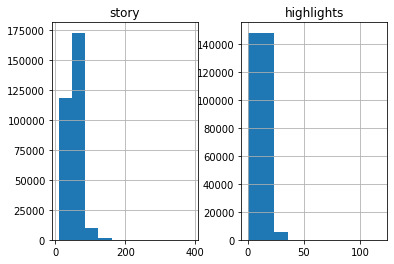

In [36]:
# show data distribution

text_count = []
summary_count = []
for sent in df_cnndm['story']:
    text_count.append(len(sent.split()))
for sent in df_cnndm['highlights']:
    summary_count.append(len(sent.split()))

graph_df= pd.DataFrame()
graph_df['story']=text_count
graph_df['highlights']=summary_count


graph_df.hist(bins = 10)
plt.show()

In [37]:
# see basic dataset
def count_perc_words(df,col_name='story',len_start=0,len_end=15):
  #Check how much % of summary have ... number of words.
  count=0
  for sentence in df[col_name]:
      num_word = len(sentence.split()) 
      if  (num_word >= len_start) and (num_word < len_end):
          count=count+1
  return (count/len(df[col_name]))

# print("% of story have 0 to 500 words =",count_perc_words(df_cnndm,'story',0,500))
# print("% of story have 500 to 1000 words =",count_perc_words(df_cnndm,'story',500,1000))
# print("% of story have 1000 to 1500 words =",count_perc_words(df_cnndm,'story',1000,1500))
# print("% of story have more than 1500 words =",count_perc_words(df_cnndm,'story',1500,9900))

# print("% of highlight have 0 to 50 words =",count_perc_words(df_cnndm,'highlights',0,50))
# print("% of highlight have 50 to 100 words =",count_perc_words(df_cnndm,'highlights',50,100))
# print("% of highlight have more than 100 words =",count_perc_words(df_cnndm,'highlights',100,9900))



In [38]:

#Shorten the Summaries and Text between max len defined above
def count_word(sentence):
  return len(sentence.split(' '))

# count #word in highlight/summary
df_cnndm['num_word_highlights'] = df_cnndm.apply(lambda row: count_word(row['highlights']), axis=1)
# count #word in story
df_cnndm['num_word_story'] = df_cnndm.apply(lambda row: count_word(row['story']), axis=1)

print('max num_word_highlights:',max(df_cnndm['num_word_highlights']),'max num_word_story:',max(df_cnndm['num_word_story']))
print('mean num_word_highlights:',np.mean(df_cnndm['num_word_highlights']),'max num_word_story:',np.mean(df_cnndm['num_word_story']))
print('median num_word_highlights:',np.median(df_cnndm['num_word_highlights']),'max num_word_story:',np.median(df_cnndm['num_word_story']))


df_cnndm.head(5)

max num_word_highlights: 118 max num_word_story: 388
mean num_word_highlights: 12.434069864483567 max num_word_story: 53.13195631151559
median num_word_highlights: 12.0 max num_word_story: 51.0


,story,highlights,id,num_word_highlights,num_word_story
0,controversial malawi president bingu wa mutharika had won power in the african state in but was unpopular among his countrymen bingu wa mutharika the controversial president of malawi who saw the ...,controversial leader collapsed on thursday but could not be saved,id_dm_143548,10,46
1,arizonans thats who it figures in the immigration debate the state that has demonstrated that it is terrified of changing demographics and determined to run off latinos seems afraid of its own cul...,arizona judge rules for group trying to stop school districts mexicanamerican studies,id_cnn_66720,12,58
2,northwestern universitys football players voted friday on whether to form a workers union one of the most highprofile efforts by college athletes to demand more rights possibly including payment b...,northwestern university football players vote friday on whether to unionize,id_cnn_91222,10,41
3,a european union delegation met saturday with zimbabwe president robert mugabe who said the parties had established a good rapport president mugabe and his wife grace arrive for a zanu pf party yo...,of eu meeting mugabe said there was no animosity it was quite friendly,id_cnn_53005,13,36
4,world player of the year lionel messi grabbed his second straight hattrick in spains la liga to power barcelona to a in over real zaragoza on sunday night messi who scored twice in the midweek cha...,lionel messi continues his incredible scoring spree for barcelona,id_cnn_21168,9,61


In [39]:
# filter out some data based on length
MAX_LEN_TEXT=100
MAX_LEN_SUM=30

MIN_LEN_TEXT = 10
MIN_LEN_SUM = 5

df_cnndm=df_cnndm[ (df_cnndm['num_word_highlights']>MIN_LEN_SUM) & (df_cnndm['num_word_highlights']<=MAX_LEN_SUM) \
             & (df_cnndm['num_word_story']>MIN_LEN_TEXT) & (df_cnndm['num_word_story']<=MAX_LEN_TEXT)]

df_cnndm.shape

(295758, 5)

In [40]:
# put _START_ and _END_ tokens at shorten_highlights
df_cnndm.loc[:,'shorten_highlights']= df_cnndm['highlights']
df_cnndm.loc[:,'shorten_story']= df_cnndm['story']

df_cnndm['shorten_highlights'] = '_START_ '+df_cnndm['shorten_highlights'].astype(str)+' _END_'

# add sostok and eostok (token) to shorten_highlights
df_cnndm['shorten_highlights'] = df_cnndm.apply(lambda row : 'sostok '+ row['shorten_highlights'] + ' eostok',axis=1)

df_cnndm.head(5)

,story,highlights,id,num_word_highlights,num_word_story,shorten_highlights,shorten_story
0,controversial malawi president bingu wa mutharika had won power in the african state in but was unpopular among his countrymen bingu wa mutharika the controversial president of malawi who saw the ...,controversial leader collapsed on thursday but could not be saved,id_dm_143548,10,46,sostok _START_ controversial leader collapsed on thursday but could not be saved _END_ eostok,controversial malawi president bingu wa mutharika had won power in the african state in but was unpopular among his countrymen bingu wa mutharika the controversial president of malawi who saw the ...
1,arizonans thats who it figures in the immigration debate the state that has demonstrated that it is terrified of changing demographics and determined to run off latinos seems afraid of its own cul...,arizona judge rules for group trying to stop school districts mexicanamerican studies,id_cnn_66720,12,58,sostok _START_ arizona judge rules for group trying to stop school districts mexicanamerican studies _END_ eostok,arizonans thats who it figures in the immigration debate the state that has demonstrated that it is terrified of changing demographics and determined to run off latinos seems afraid of its own cul...
2,northwestern universitys football players voted friday on whether to form a workers union one of the most highprofile efforts by college athletes to demand more rights possibly including payment b...,northwestern university football players vote friday on whether to unionize,id_cnn_91222,10,41,sostok _START_ northwestern university football players vote friday on whether to unionize _END_ eostok,northwestern universitys football players voted friday on whether to form a workers union one of the most highprofile efforts by college athletes to demand more rights possibly including payment b...
3,a european union delegation met saturday with zimbabwe president robert mugabe who said the parties had established a good rapport president mugabe and his wife grace arrive for a zanu pf party yo...,of eu meeting mugabe said there was no animosity it was quite friendly,id_cnn_53005,13,36,sostok _START_ of eu meeting mugabe said there was no animosity it was quite friendly _END_ eostok,a european union delegation met saturday with zimbabwe president robert mugabe who said the parties had established a good rapport president mugabe and his wife grace arrive for a zanu pf party yo...
4,world player of the year lionel messi grabbed his second straight hattrick in spains la liga to power barcelona to a in over real zaragoza on sunday night messi who scored twice in the midweek cha...,lionel messi continues his incredible scoring spree for barcelona,id_cnn_21168,9,61,sostok _START_ lionel messi continues his incredible scoring spree for barcelona _END_ eostok,world player of the year lionel messi grabbed his second straight hattrick in spains la liga to power barcelona to a in over real zaragoza on sunday night messi who scored twice in the midweek cha...


In [41]:
# example of processed data
print(df_cnndm.loc[20,'shorten_story'])
print(df_cnndm.loc[2,'shorten_story'])
df_cnndm.loc[2,'shorten_highlights'],df_cnndm.loc[20,'shorten_highlights']


this is the bizarre sight of thousands of videos which have been dumped on farmland by suspected flytippers the unwanted collection of tapes includes everything from james bond through to bob the builder and a carol vorderman fitness video
northwestern universitys football players voted friday on whether to form a workers union one of the most highprofile efforts by college athletes to demand more rights possibly including payment but the result of the vote might not be known for months


('sostok _START_ northwestern university football players vote friday on whether to unionize _END_ eostok',
 'sostok _START_ tapes include everything from bob the builder through to james bond _END_ eostok')

In [42]:
# split data train/validation
X_train,X_vali,Y_train,Y_vali=train_test_split(np.array(df_cnndm['shorten_story']),np.array(df_cnndm['shorten_highlights']),train_size=0.90,random_state=0,shuffle=False)
X_train.shape, X_vali.shape, Y_train.shape, Y_vali.shape
# train/val: 266182, 29576 , total = 295758


((266182,), (29576,), (266182,), (29576,))

In [43]:
%%time

#prepare a tokenizer for stories of training data
X_tokenizer = Tokenizer() 
X_tokenizer.fit_on_texts(list(X_train))

threshold=4

count=0
total_count=0
frequency=0
total_freq=0

for key,value in X_tokenizer.word_counts.items():
    total_count += 1
    total_freq += value
    if(value < threshold):
        count=count+1
        frequency=frequency+value
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_freq)*100)

#prepare a tokenizer for stories of training data
X_tokenizer = Tokenizer(num_words=total_count-count) 
X_tokenizer.fit_on_texts(list(X_train))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
X_train_seq    =   X_tokenizer.texts_to_sequences(X_train) 
X_vali_seq   =   X_tokenizer.texts_to_sequences(X_vali)

#padding zero upto maximum length
X_train    =   pad_sequences(X_train_seq,  maxlen=MAX_LEN_TEXT, padding='post')
X_vali   =   pad_sequences(X_vali_seq, maxlen=MAX_LEN_TEXT, padding='post')

#size of vocabulary ( +1 for padding token)
X_voc   =  X_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(X_voc))

% of rare words in vocabulary: 65.46420101055237
Total Coverage of rare words: 1.1496141966465028
Size of vocabulary in X = 60286
CPU times: user 49 s, sys: 44.4 ms, total: 49.1 s
Wall time: 50.8 s


In [44]:
%%time
Y_tokenizer = Tokenizer()   
Y_tokenizer.fit_on_texts(list(Y_train))

threshold=6

count=0
total_count=0
frequency=0
total_freq=0

for key,value in Y_tokenizer.word_counts.items():
    total_count += 1
    total_freq += value
    if(value < threshold):
        count += 1
        frequency += value
    
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_freq)*100)

#prepare a tokenizer for summaries of training data
Y_tokenizer = Tokenizer(num_words=total_count-count) 
Y_tokenizer.fit_on_texts(list(Y_train))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
Y_train_seq    =   Y_tokenizer.texts_to_sequences(Y_train)
Y_vali_seq   =   Y_tokenizer.texts_to_sequences(Y_vali) 

#padding zero upto maximum length
Y_train    =   pad_sequences(Y_train_seq, maxlen=MAX_LEN_SUM, padding='post')
Y_vali   =   pad_sequences(Y_vali_seq, maxlen=MAX_LEN_SUM, padding='post')

#size of vocabulary
Y_voc  =   Y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(Y_voc))

% of rare words in vocabulary: 76.24843699448249
Total Coverage of rare words: 3.3273843982612212
Size of vocabulary in Y = 27164
CPU times: user 20.6 s, sys: 23.9 ms, total: 20.6 s
Wall time: 21.3 s


In [45]:
# We will now remove "Summary" i.e Y (both train and val) which has only START and END
idx=[]
for i in range(len(Y_train)):
    count=0
    for j in Y_train[i]:
        if j != 0:
            count += 1
    if(count == 2):
        idx.append(i)

Y_train=np.delete(Y_train,idx, axis=0)
X_train=np.delete(X_train,idx, axis=0)

idx=[]
for i in range(len(Y_vali)):
    count=0
    for j in Y_vali[i]:
        if j != 0:
            count += 1
    if(count == 2):
        idx.append(i)

Y_vali=np.delete(Y_vali,idx, axis=0)
X_vali=np.delete(X_vali,idx, axis=0)

In [46]:
##if using TPU
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.3.0
Running on TPU  ['10.17.248.34:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.17.248.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.17.248.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [47]:
print("Size of vocabulary from the w2v model = {}".format(X_voc))

K.clear_session()

Size of vocabulary from the w2v model = 60286


In [48]:
# set hidden dimensions
latent_dim = 300
embedding_dim=200

# TPU scope
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU

  # Encoder
  encoder_inputs = Input(shape=(MAX_LEN_TEXT,))

  #embedding layer
  enc_emb =  Embedding(X_voc, embedding_dim,trainable=True)(encoder_inputs)

  #encoder lstm 1
  encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0)

  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

  #encoder lstm 2
  encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0)

  encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

  #encoder lstm 3
  encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0)

  encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [49]:
# if use TPU
# creating the model in the TPUStrategy scope means we will train the model on the TPU
with tpu_strategy.scope(): 

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = Input(shape=(None,))

  #embedding layer
  dec_emb_layer = Embedding(Y_voc, embedding_dim,trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  # decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
  decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0)

  decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

  #dense layer
  decoder_dense =  TimeDistributed(Dense(Y_voc, activation='softmax'))
  decoder_outputs = decoder_dense(decoder_outputs)

  # Define the model 
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [50]:
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     12057200    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [51]:
# set optimizer and loss function
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [52]:
# set early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)


In [53]:
%%time
## fitting with TPU
history=model.fit([X_train,Y_train[:,:-1]], Y_train.reshape(Y_train.shape[0],Y_train.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512 * tpu_strategy.num_replicas_in_sync, validation_data=([X_vali,Y_vali[:,:-1]], Y_vali.reshape(Y_vali.shape[0],Y_vali.shape[1], 1)[:,1:]))

## fitting with CPU/GPU
# history=model.fit([X_train,Y_train[:,:-1]], Y_train.reshape(Y_train.shape[0],Y_train.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=32, validation_data=([X_vali,Y_vali[:,:-1]], Y_vali.reshape(Y_vali.shape[0],Y_vali.shape[1], 1)[:,1:]))

Epoch 1/50
 2/65 [..............................] - ETA: 8s - loss: 10.1943WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0023s vs `on_train_batch_end` time: 0.2634s). Check your callbacks.


65/65 [==============================] - ETA: 0s - loss: 4.1848WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_test_batch_end` time: 0.0801s). Check your callbacks.


65/65 [==============================] - 31s 478ms/step - loss: 4.1848 - val_loss: 3.3448
Epoch 2/50
65/65 [==============================] - 18s 281ms/step - loss: 3.2580 - val_loss: 3.1219
Epoch 3/50
65/65 [==============================] - 18s 278ms/step - loss: 3.1179 - val_loss: 3.0479
Epoch 4/50
65/65 [==============================] - 18s 280ms/step - loss: 3.0581 - val_loss: 2.9952
Epoch 5/50
65/65 [==============================] - 18s 279ms/step - loss: 2.9933 - val_loss: 2.9225
Epoch 6/50
65/65 [==============================] - 18s 277ms/step - loss: 2.9204 - val_loss: 2.8569
Epoch 7/50
65/65 [==============================] - 18s 278ms/step - loss: 2.8618 - val_loss: 2.8080
Epoch 8/50
65/65 [==============================] - 18s 279ms/step - loss: 2.8119 - val_loss: 2.7654
Epoch 9/50
65/65 [==============================] - 18s 279ms/step - loss: 2.7611 - val_loss: 2.7161
Epoch 10/50
65/65 [==============================] - 18s 279ms/step - loss: 2.7115 - val_loss: 2.6775


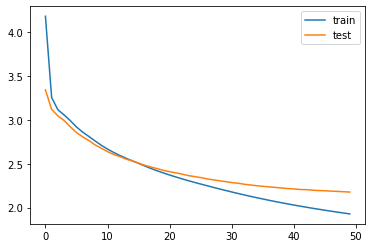

In [54]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [55]:
# # save loss into json for later plotting
# save_loc = ''
# list all data in history
# print(history.history.keys())
# Get the dictionary containing each metric and the loss for each epoch
# history_dict = history.history

# Save it under the form of a json file
# json.dump(history_dict, open(save_loc+'/history_loss.json', 'w'))



In [56]:
###### SAVE models and weights ######

# # https://stackoverflow.com/questions/48158547/restore-keras-seq2seq-model
# save_loc = '/content/drive/My Drive/Colab Notebooks/data'
# with open(save_loc+'/encoder_model.json', 'w', encoding='utf8') as f:
#     f.write(encoder_model.to_json())
# encoder_model.save_weights(save_loc+'/encoder_model_weights.h5')

# with open(save_loc+'/decoder_model.json', 'w', encoding='utf8') as f:
#     f.write(decoder_model.to_json())
# decoder_model.save_weights(save_loc+'/decoder_model_weights.h5')

In [57]:
reverse_target_word_index=Y_tokenizer.index_word
reverse_source_word_index=X_tokenizer.index_word
target_word_index=Y_tokenizer.word_index

In [60]:

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(MAX_LEN_TEXT,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [61]:

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (MAX_LEN_SUM-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence
    
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [62]:
%%time

# example of predicted summaries
for i in range(0,10):
# for i in tqdm(range(0,10000)):

    # print("Story:",seq2text(X_train[i]))
    # print("Original summary:",seq2summary(Y_train[i]))
    # print("Predicted summary:",decode_sequence(X_train[i].reshape(1,MAX_LEN_TEXT)))
    # print("\n")
    print("Story:",seq2text(X_vali[i]))
    print("Original summary:",seq2summary(Y_vali[i]))
    print("Predicted summary:",decode_sequence(X_vali[i].reshape(1,MAX_LEN_TEXT)))
    print("\n")


print(len(X_train))

Story: lawsuit minneapolis priest michael keating pictured is being sued for allegedly sexually abusing a girl for three years a decade and a half ago a minneapolis priest sent at least seductive emails confessing his love to a teenage girl who he was allegedly sexually abusing for a period of three years a ago 
Original summary: start the victim who was when the alleged abuse started and is in her late now filed a lawsuit against twin cities minnesota reverend michael jerome keating monday end 
Predicted summary:  start michael brewer allegedly abused the girl at the altar in end


Story: aaron hernandez was destined to be a football superstar and was already one of the nfls most promising tight ends but less than a year after signing a million contract extension with the football powerhouse new england patriots he was charged with firstdegree murder 
Original summary: start aaron hernandez former football star is behind bars facing three murder charges end 
Predicted summary:  start 

# 3. Pre-trained Transformers (Bart-large, T5-small, T5-base, and T5-large)

In [4]:
!pip install transformers 
import torch
torch.cuda.is_available()

True

In [6]:
from transformers import AutoModelWithLMHead, AutoTokenizer
model = AutoModelWithLMHead.from_pretrained("t5-base")
tokenizer = AutoTokenizer.from_pretrained("t5-base")

# t5-small, t5-large, facebook/bart-large

/usr/local/lib/python3.6/dist-packages/transformers/models/auto/modeling_auto.py:852: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Some weights of the model checkpoint at t5-base were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

path_test= '/content/drive/My Drive/Colab Notebooks/data/test_dataset.pkl'

stories = pickle.load(open(path_test, 'rb'))
print("total number of CNN data: ",len(stories))

Mounted at /content/drive
total number of CNN data:  10000


In [8]:
import pandas as pd
df = pd.DataFrame(stories)

def shorten_sen(list_sen, NUM_SEN=2):
  final_sen =[]
  if len(list_sen) < NUM_SEN:
    NUM_SEN = len(list_sen)
  for i in range(NUM_SEN):
    final_sen.append(list_sen[i])
  return '. '.join(final_sen)# + '.'

df['shorten_story'] = df.apply(lambda row: shorten_sen(row['story']), axis=1)
df['shorten_highlights'] = df.apply(lambda row: row['highlights'][0], axis=1)

df['predicted_highlights'] = '-'
df.head(5)

# df.iloc[0,4]#, df.iloc[0,0] 

,story,highlights,id,shorten_story,shorten_highlights,predicted_highlights
0,[ever hopped in a taxi and sat in traffic for ...,[mellowcab is a threewheeled vehicle that the ...,id_cnn_88698,ever hopped in a taxi and sat in traffic for h...,mellowcab is a threewheeled vehicle that the o...,-
1,[a mother of six has claimed she was threatene...,[amanda moss and husband simon booked family h...,id_dm_26727,a mother of six has claimed she was threatened...,amanda moss and husband simon booked family ho...,-
2,[thomas morris who was strangled by his own ka...,[thomas morris was found dead in home gym in m...,id_dm_205431,thomas morris who was strangled by his own kar...,thomas morris was found dead in home gym in mo...,-
3,[britains princess anne and major winner annik...,"[ra announces first women members, princess an...",id_cnn_47838,britains princess anne and major winner annika...,ra announces first women members,-
4,[it is alleged that michael karkoc was an offi...,[alleged michael karkoc was in the ssled ukran...,id_dm_63684,it is alleged that michael karkoc was an offic...,alleged michael karkoc was in the ssled ukrani...,-


In [9]:
%%time
from tqdm import tqdm
from tqdm import tqdm_notebook


for i in tqdm_notebook(range(0,10)):
# for i in tqdm_notebook(range(0,2000)):

# for i in tqdm_notebook(range(0,len(df))):

    article= df.loc[i,'shorten_story']
    # encode the text into tensor of integers using the appropriate tokenizer
    inputs = tokenizer.encode("summarize: " + article,
                          return_tensors="pt", max_length=200, truncation=True)#.to('cuda:0')
                          # return_tensors="pt", max_length=512, truncation=True).to('cuda:0')

    # generate the summarization output
    outputs = model.generate(
        inputs,
        max_length=30,
        min_length=10,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True)
    df.loc[i,'predicted_highlights']=tokenizer.decode(outputs[0])
    # print()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



CPU times: user 32 s, sys: 264 ms, total: 32.3 s
Wall time: 32.5 s


In [ ]:
# loc_save = '/content/drive/My Drive/Colab Notebooks/data'

# df.to_csv(loc_save+'/saved_predicted_sum.csv')

In [11]:
index = 2
df.iloc[index,4], df.iloc[index,0],df.iloc[index,1], df.iloc[index,3] 

('thomas morris was found dead in home gym in morriston swansea',
 ['thomas morris who was strangled by his own karate belt in a freak accident while carrying out a martial arts exercise',
  'a teenage fitness fanatic accidentally strangled himself with a karate belt after trying out a martial arts exercise he had seen on the internet an inquest has heard',
  'thomas morris was found dead in his home gym in morriston swansea with the belt around his neck after trying to copy the training exercise',
  'an inquest heard the karate fan had viewed the online training video of martial arts experts using their belt under their chin',
  'the coroner heard that thomas who was also a talented rugby player had shown his sisters the exercise which he hoped would build up his fitness',
  'his mother belinda and his cousins went to look for thomas in the gym in an outbuilding in the garden when she returned from an afternoon out and found him along with the belt wrapped around his neck',
  'detecti

# Model Evaluation: ROUGE

In [12]:
!pip install rouge
from rouge import Rouge 
import pandas as pd
import numpy as np

In [13]:
import pandas as pd

path_file= '/content/drive/My Drive/Colab Notebooks/data/t5large_predicted_sum.csv'
df = pd.read_csv(path_file)

#drop row with nan in predicted highlights or reference highlights
df = df[df['shorten_highlights'].notna()]
df = df[df['predicted_highlights'].notna()]

# reindex 
df = df.reset_index(drop=True)

print("shape after drop NaN: ",df.shape)
# df.loc[i,'predicted_highlights']
df.head(5)

shape after drop NaN:  (9999, 7)


,Unnamed: 0,story,highlights,id,shorten_story,shorten_highlights,predicted_highlights
0,0,['ever hopped in a taxi and sat in traffic for...,['mellowcab is a threewheeled vehicle that the...,id_cnn_88698,ever hopped in a taxi and sat in traffic for h...,mellowcab is a threewheeled vehicle that the o...,taxis remain a common mode of getting around i...
1,1,['a mother of six has claimed she was threaten...,['amanda moss and husband simon booked family ...,id_dm_26727,a mother of six has claimed she was threatened...,amanda moss and husband simon booked family ho...,amanda moss claims she was threatened with a c...
2,2,['thomas morris who was strangled by his own k...,['thomas morris was found dead in home gym in ...,id_dm_205431,thomas morris who was strangled by his own kar...,thomas morris was found dead in home gym in mo...,thomas morris was strangled by his own karate ...
3,3,['britains princess anne and major winner anni...,"['ra announces first women members', 'princess...",id_cnn_47838,britains princess anne and major winner annika...,ra announces first women members,princess anne and major winner annika sorensta...
4,4,['it is alleged that michael karkoc was an off...,['alleged michael karkoc was in the ssled ukra...,id_dm_63684,it is alleged that michael karkoc was an offic...,alleged michael karkoc was in the ssled ukrani...,michael karkoc is accused of being a notorious...


In [14]:
# get highlight, pred highlight, id to lists for ROUGE calculation
list_pred = []
list_ref =[]
list_id = []

for i in range(0,len(df)):
  list_pred.append(df.loc[i,'predicted_highlights'])
  list_ref.append(df.loc[i,'shorten_highlights'])
  list_id.append(df.loc[i,'id'])
# list_pred, list_ref

In [15]:
# calculate with ROUGE metric
rouge = Rouge()
scores = rouge.get_scores(list_pred, list_ref)



In [16]:
df_scores = pd.DataFrame(scores)
df_scores['id'] = list_id
df_scores

,rouge-1,rouge-2,rouge-l,id
0,"{'f': 0.12121211625344373, 'p': 0.111111111111...","{'f': 0.0, 'p': 0.0, 'r': 0.0}","{'f': 0.06451612407908468, 'p': 0.058823529411...",id_cnn_88698
1,"{'f': 0.25806451175858486, 'p': 0.190476190476...","{'f': 0.13793103020214045, 'p': 0.1, 'r': 0.22...","{'f': 0.27586206444708683, 'p': 0.210526315789...",id_dm_26727
2,"{'f': 0.28571428094387763, 'p': 0.235294117647...","{'f': 0.1538461491124262, 'p': 0.125, 'r': 0.2}","{'f': 0.2962962916323732, 'p': 0.2352941176470...",id_dm_205431
3,"{'f': 0.21428571135204083, 'p': 0.130434782608...","{'f': 0.1538461512426036, 'p': 0.0909090909090...","{'f': 0.2399999968, 'p': 0.15, 'r': 0.6}",id_cnn_47838
4,"{'f': 0.13793102977407862, 'p': 0.111111111111...","{'f': 0.0740740694101512, 'p': 0.0588235294117...","{'f': 0.13793102977407862, 'p': 0.111111111111...",id_dm_63684
...,...,...,...,...
9994,"{'f': 0.2666666618666667, 'p': 0.2222222222222...","{'f': 0.14285713808673486, 'p': 0.117647058823...","{'f': 0.2666666618666667, 'p': 0.2222222222222...",id_dm_183675
9995,"{'f': 0.0, 'p': 0.0, 'r': 0.0}","{'f': 0.0, 'p': 0.0, 'r': 0.0}","{'f': 0.0, 'p': 0.0, 'r': 0.0}",id_dm_14557
9996,"{'f': 0.36842104813019394, 'p': 0.28, 'r': 0.5...","{'f': 0.2777777733333334, 'p': 0.2083333333333...","{'f': 0.38888888427469137, 'p': 0.304347826086...",id_cnn_90018
9997,"{'f': 0.3124999951757813, 'p': 0.2631578947368...","{'f': 0.1333333285333335, 'p': 0.1111111111111...","{'f': 0.2666666617555556, 'p': 0.2352941176470...",id_dm_192809


In [17]:
# create new column names
list_rouge = list(df_scores)
list_rouge = [rouge.upper() for rouge in list_rouge]
list_metric = ['F1','Precision','Recall']

list_col_name = []

for rouge in list_rouge:
  for metric in list_metric:
    list_col_name.append(rouge+'_'+metric)

list_col_name

['ROUGE-1_F1',
 'ROUGE-1_Precision',
 'ROUGE-1_Recall',
 'ROUGE-2_F1',
 'ROUGE-2_Precision',
 'ROUGE-2_Recall',
 'ROUGE-L_F1',
 'ROUGE-L_Precision',
 'ROUGE-L_Recall',
 'ID_F1',
 'ID_Precision',
 'ID_Recall']

In [18]:
# create new columns
for col in list_col_name:
  # if column not exist, create new one
  if col not in df_scores:
    df_scores[col] = '-'
df_scores.head(5)

,rouge-1,rouge-2,rouge-l,id,ROUGE-1_F1,ROUGE-1_Precision,ROUGE-1_Recall,ROUGE-2_F1,ROUGE-2_Precision,ROUGE-2_Recall,ROUGE-L_F1,ROUGE-L_Precision,ROUGE-L_Recall,ID_F1,ID_Precision,ID_Recall
0,"{'f': 0.12121211625344373, 'p': 0.111111111111...","{'f': 0.0, 'p': 0.0, 'r': 0.0}","{'f': 0.06451612407908468, 'p': 0.058823529411...",id_cnn_88698,-,-,-,-,-,-,-,-,-,-,-,-
1,"{'f': 0.25806451175858486, 'p': 0.190476190476...","{'f': 0.13793103020214045, 'p': 0.1, 'r': 0.22...","{'f': 0.27586206444708683, 'p': 0.210526315789...",id_dm_26727,-,-,-,-,-,-,-,-,-,-,-,-
2,"{'f': 0.28571428094387763, 'p': 0.235294117647...","{'f': 0.1538461491124262, 'p': 0.125, 'r': 0.2}","{'f': 0.2962962916323732, 'p': 0.2352941176470...",id_dm_205431,-,-,-,-,-,-,-,-,-,-,-,-
3,"{'f': 0.21428571135204083, 'p': 0.130434782608...","{'f': 0.1538461512426036, 'p': 0.0909090909090...","{'f': 0.2399999968, 'p': 0.15, 'r': 0.6}",id_cnn_47838,-,-,-,-,-,-,-,-,-,-,-,-
4,"{'f': 0.13793102977407862, 'p': 0.111111111111...","{'f': 0.0740740694101512, 'p': 0.0588235294117...","{'f': 0.13793102977407862, 'p': 0.111111111111...",id_dm_63684,-,-,-,-,-,-,-,-,-,-,-,-


In [19]:
dict_metric_name = {'r':'Recall','p':'Precision','f':'F1'}

for i in range(len(df_scores)):
  for col_name in ['rouge-1','rouge-2','rouge-l']:
    # print(col_name)
    for key,value in df_scores.loc[i,col_name].items():
      df_scores.loc[i,col_name.upper()+'_'+dict_metric_name[key]] = value 
df_scores

,rouge-1,rouge-2,rouge-l,id,ROUGE-1_F1,ROUGE-1_Precision,ROUGE-1_Recall,ROUGE-2_F1,ROUGE-2_Precision,ROUGE-2_Recall,ROUGE-L_F1,ROUGE-L_Precision,ROUGE-L_Recall,ID_F1,ID_Precision,ID_Recall
0,"{'f': 0.12121211625344373, 'p': 0.111111111111...","{'f': 0.0, 'p': 0.0, 'r': 0.0}","{'f': 0.06451612407908468, 'p': 0.058823529411...",id_cnn_88698,0.121212,0.111111,0.133333,0,0,0,0.0645161,0.0588235,0.0714286,-,-,-
1,"{'f': 0.25806451175858486, 'p': 0.190476190476...","{'f': 0.13793103020214045, 'p': 0.1, 'r': 0.22...","{'f': 0.27586206444708683, 'p': 0.210526315789...",id_dm_26727,0.258065,0.190476,0.4,0.137931,0.1,0.222222,0.275862,0.210526,0.4,-,-,-
2,"{'f': 0.28571428094387763, 'p': 0.235294117647...","{'f': 0.1538461491124262, 'p': 0.125, 'r': 0.2}","{'f': 0.2962962916323732, 'p': 0.2352941176470...",id_dm_205431,0.285714,0.235294,0.363636,0.153846,0.125,0.2,0.296296,0.235294,0.4,-,-,-
3,"{'f': 0.21428571135204083, 'p': 0.130434782608...","{'f': 0.1538461512426036, 'p': 0.0909090909090...","{'f': 0.2399999968, 'p': 0.15, 'r': 0.6}",id_cnn_47838,0.214286,0.130435,0.6,0.153846,0.0909091,0.5,0.24,0.15,0.6,-,-,-
4,"{'f': 0.13793102977407862, 'p': 0.111111111111...","{'f': 0.0740740694101512, 'p': 0.0588235294117...","{'f': 0.13793102977407862, 'p': 0.111111111111...",id_dm_63684,0.137931,0.111111,0.181818,0.0740741,0.0588235,0.1,0.137931,0.111111,0.181818,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,"{'f': 0.2666666618666667, 'p': 0.2222222222222...","{'f': 0.14285713808673486, 'p': 0.117647058823...","{'f': 0.2666666618666667, 'p': 0.2222222222222...",id_dm_183675,0.266667,0.222222,0.333333,0.142857,0.117647,0.181818,0.266667,0.222222,0.333333,-,-,-
9995,"{'f': 0.0, 'p': 0.0, 'r': 0.0}","{'f': 0.0, 'p': 0.0, 'r': 0.0}","{'f': 0.0, 'p': 0.0, 'r': 0.0}",id_dm_14557,0,0,0,0,0,0,0,0,0,-,-,-
9996,"{'f': 0.36842104813019394, 'p': 0.28, 'r': 0.5...","{'f': 0.2777777733333334, 'p': 0.2083333333333...","{'f': 0.38888888427469137, 'p': 0.304347826086...",id_cnn_90018,0.368421,0.28,0.538462,0.277778,0.208333,0.416667,0.388889,0.304348,0.538462,-,-,-
9997,"{'f': 0.3124999951757813, 'p': 0.2631578947368...","{'f': 0.1333333285333335, 'p': 0.1111111111111...","{'f': 0.2666666617555556, 'p': 0.2352941176470...",id_dm_192809,0.3125,0.263158,0.384615,0.133333,0.111111,0.166667,0.266667,0.235294,0.307692,-,-,-


In [20]:
def print_scores(df_scores):
  print("Mean scores: ROUGE-1= {}, ROUGE-2= {}, ROUGE-L= {}.".format(df_scores['ROUGE-1_F1'].mean(), df_scores['ROUGE-2_F1'].mean(), df_scores['ROUGE-L_F1'].mean()))
  print("Median scores: ROUGE-1= {}, ROUGE-2= {}, ROUGE-L= {}.".format(df_scores['ROUGE-1_F1'].median(), df_scores['ROUGE-2_F1'].median(), df_scores['ROUGE-L_F1'].median()))
  print("Max scores: ROUGE-1= {}, ROUGE-2= {}, ROUGE-L= {}.".format(df_scores['ROUGE-1_F1'].max(), df_scores['ROUGE-2_F1'].max(), df_scores['ROUGE-L_F1'].max()))
  print("Min scores: ROUGE-1= {}, ROUGE-2= {}, ROUGE-L= {}.".format(df_scores['ROUGE-1_F1'].min(), df_scores['ROUGE-2_F1'].min(), df_scores['ROUGE-L_F1'].min()))

# ROUGE scores
print_scores(df_scores)

Mean scores: ROUGE-1= 0.2806488470966627, ROUGE-2= 0.13392605023021345, ROUGE-L= 0.2641153111629091.
Median scores: ROUGE-1= 0.23999999520000007, ROUGE-2= 0.07142856665816359, ROUGE-L= 0.21428570969387764.
Max scores: ROUGE-1= 0.999999995, ROUGE-2= 0.999999995, ROUGE-L= 0.999999995.
Min scores: ROUGE-1= 0.0, ROUGE-2= 0.0, ROUGE-L= 0.0.
